In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import itertools as it
import qutip as qt
import scipy.optimize as opt
from plotting_functions import *
# 
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{physics}')

viridis = cm.get_cmap('viridis')
cmap_viridis = viridis(np.linspace(0, 1, 8))

# Plot Kraus operators for pi/2

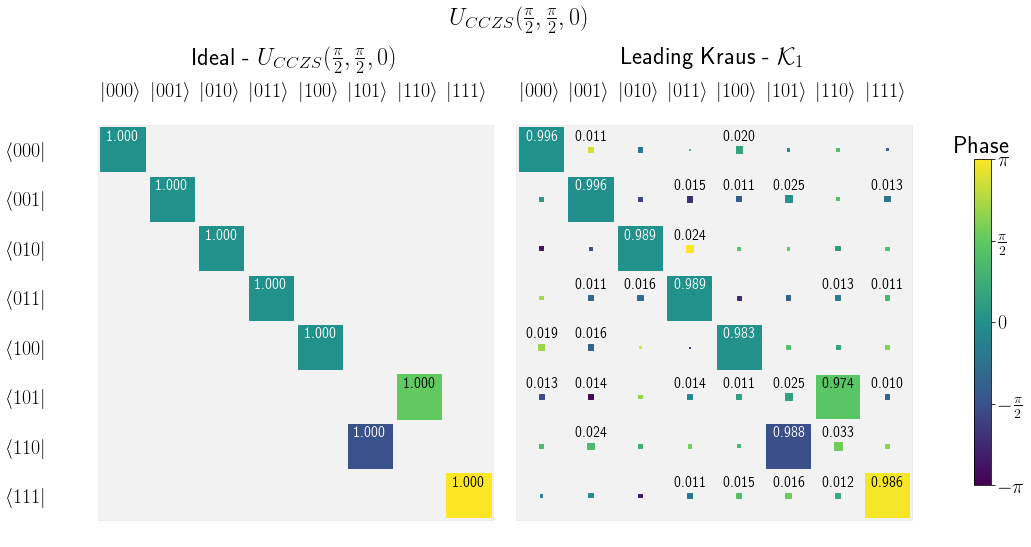

In [7]:
kraus_ideal = qt.Qobj(np.load(r'..\..\Data\Fig3 Data\kraus_ideal_pi2.npy'), dims=((2,2,2),(2,2,2)))
kraus_recon = qt.Qobj(np.load(r'..\..\Data\Fig3 Data\kraus_recon_pi2.npy'), dims=((2,2,2),(2,2,2)))
kraus_ideal._type='oper'
kraus_recon._type='oper'

U_diff = kraus_ideal - kraus_recon
U_diff._type='oper'

fig, ax = plt.subplots(1, 2, figsize = (20, 8))

fig.subplots_adjust(hspace=0, wspace=-0.4)
fig1, ax1 = hinton_phase(kraus_recon, ax=ax[1], cmap=viridis, ylabels=[None]*8, text=True)
_ =ax1.set_title(r'Leading Kraus - $\mathcal{K}_1$', fontsize=24, y=1.08)
fig2, ax2 = hinton_phase(kraus_ideal, ax=ax[0], cmap=viridis, cbar=False, text=True)
_ = ax2.set_title(r'Ideal - $U_{CCZS}(\frac{\pi}{2}, \frac{\pi}{2}, 0)$', fontsize=24, y=1.08)
_ = plt.suptitle(r'$U_{CCZS}(\frac{\pi}{2}, \frac{\pi}{2}, 0)$', fontsize=24, y=1.05, x=0.45)

# plt.savefig(r'U_ideal_LK_approx_pi2pi20.pdf', dpi=800)

# Plot Bootstrap Distributions

In [8]:
num_qubits = 3

op_label = [['i', 'x', 'y', 'z']] * num_qubits

measurement_labels = list(it.product(['0', '1'], repeat=num_qubits))
measurement_idx = (0, 4, 2, 6, 1, 5, 3, 7) # mask for reordering index labels from |q2,q1,q0> -> |q0,q1,q2> notation
measurement_labels = ["".join(p) for p in measurement_labels]

In [9]:
def gaussian(x, std, mu):
    return (1/np.sqrt(np.pi*2*std**2))*np.exp(-0.5*(x/std - mu/std)**2)

def U_CZS(theta, phi, gamma):
    """

    Args:
        theta (float): [description]
        phi (float): [description]
        gamma (float): [description]

    Returns:
        jnp.array: [description]
    """
    gamma_term = np.exp(1j*gamma)
    U = np.diag([1, 1, 1, 1]) + 0j
    U[1,1] = -gamma_term*np.sin(theta/2)**2 + np.cos(theta/2)**2
    U[2,2] = -gamma_term*np.cos(theta/2)**2 + np.sin(theta/2)**2
    U[3,3] = -gamma_term
    U[1,2] = 0.5*(1 + gamma_term)*np.exp(-1j*phi)*np.sin(theta)
    U[2,1] = 0.5*(1 + gamma_term)*np.exp(1j*phi)*np.sin(theta)
    return U

def U_CCZS(theta, phi, gamma):
    zero = qt.basis(2, 0).proj()
    one = qt.basis(2, 1).proj()

    UCZS = qt.Qobj(U_CZS(theta, phi, gamma))
    
    UCCZS = qt.tensor([zero, qt.qeye(4)]) + qt.tensor([one, UCZS])
    UCCZS.dims = [[2, 2, 2], [2, 2, 2]]
    return UCCZS    

In [19]:

boot_data = np.array([np.load(r'..\..\Data\Fig3 Data\QPT_Data\BootStrapFidelity_Phi{}_250ns_Boot1000.npy'.format(i)) for i in range(5)])
opt_data = np.array([np.load(r'..\..\Data\Fig3 Data\QPT_Data\BootStrapOptFidelity_Phi{}_250ns_Boot1000.npy'.format(i)) for i in range(5)])
angle_data = np.array([np.load(r'..\..\Data\Fig3 Data\QPT_Data\BootStrapAngles_Phi{}_250ns_Boot1000.npy'.format(i)) for i in range(5)])




boot_mu = np.mean(boot_data, axis=1)
boot_std = np.std(boot_data, axis=1)

opt_mu = np.mean(opt_data, axis=1)
opt_std = np.std(opt_data, axis=1)

angle_mu = np.mean(angle_data, axis=1)
angle_std = np.std(angle_data, axis=1)


(5,)


c:\Users\warrenc\Miniconda3\envs\newbase\lib\site-packages\ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator


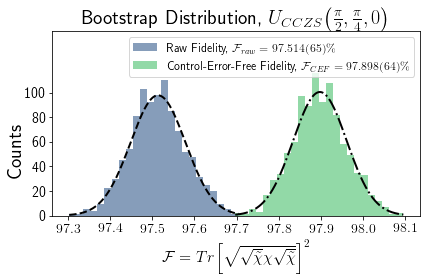

In [22]:
phi_id = 1

F_test_raw = np.linspace(np.min(boot_data[phi_id]), np.max(boot_data[phi_id]), 1001)
F_test_opt = np.linspace(np.min(opt_data[phi_id]), np.max(opt_data[phi_id]), 1001)
g1 = gaussian(F_test_raw, boot_std[phi_id], boot_mu[phi_id])
g2 = gaussian(F_test_opt, opt_std[phi_id], opt_mu[phi_id])

# fid_point = qt.fidelity(theory_data_qutip[idx].unit(), exp_data_qutip[idx].unit())**2

counts1, bins1, _ = plt.hist(boot_data[phi_id, :]*100, 
         bins='auto', 
         density=False, 
         alpha=0.6, 
         label=r'Raw Fidelity, $\mathcal{}_{} = {:.3f}({:.0f})\%$'.format(r'{F}', r'{raw}', boot_mu[phi_id]*100, boot_std[phi_id]*100*1000), 
         color=cmap_viridis[2])
# plt.plot(F_test_raw*100,
#          g1*0.16, 
#          label=r'Fit $\mathcal{} = {:.3f}\pm{:.3f}\%$'.format(r'{F}', boot_mu*100, boot_std*100), 
#          color='k', 
#          lw=2,
#          linestyle='--' )
plt.plot(F_test_raw*100,
         g1*0.16, #normalized to counts
         color='k', 
         lw=2,
         linestyle='--' )

counts2, bins2, _ =plt.hist(opt_data[phi_id, :]*100, 
         bins='auto', 
         density=False, 
         alpha=0.6, 
         label=r'Control-Error-Free Fidelity, $\mathcal{}_{} = {:.3f}({:.0f})\%$'.format(r'{F}', r'{CEF}',opt_mu[phi_id]*100, opt_std[phi_id]*100*1000), 
         color=cmap_viridis[5])
plt.plot(F_test_opt*100,
         g2*0.16, #normalize to counts
        #  label=r'Fit $\mathcal{} = {:.3f}\pm{:.3f}\%$'.format(r'{F}', opt_mu*100, opt_std*100), 
         color='k', 
         lw=2,
         linestyle='-.' )
# plt.plot(F_test_opt*100,
#          g2*0.16, 
#          label=r'Fit $\mathcal{} = {:.3f}\pm{:.3f}\%$'.format(r'{F}', opt_mu*100, opt_std*100), 
#          color='k', 
#          lw=2,
#          linestyle='-.' )

    
# plt.plot([fid_point*100]*2, 
#          [0, gaussian(fid_point, F_std, F_mu)*0.30], 
#          '--k', 
#          label=r'Point Estimate, $\mathcal{}={:.3f}$\%'.format(r'{F}', fid_point*100))



plt.xlabel(r'${}$'.format(r'\mathcal{F}=Tr\qty[\sqrt{\sqrt{\tilde{\chi}}\chi\sqrt{\tilde{\chi}}}]^2'), fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(r'Counts', fontsize=20)
plt.legend(fontsize=12)
plt.ylim([0, 150])
ax = plt.gca()
ax.set_yticklabels([0, 20, 40, 60, 80, 100])
ax.yaxis.set_label_coords(-0.075,0.35)
ticks = ax.yaxis.get_major_ticks()
ticks[-2].set_visible(False)
ticks[-3].set_visible(False)


# Change title for different index
plt.title(r'Bootstrap Distribution, $U_{CCZS}\qty(\frac{\pi}{2}, \frac{\pi}{4}, 0)$', fontsize=20, pad=1.5)
plt.tight_layout()


# plt.savefig('BootstrapDistribution_RawOpt.pdf', dpi=800)

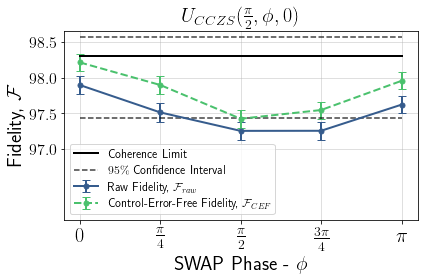

In [24]:
n_sigma = 2

plt.errorbar(np.arange(5),
             boot_mu*100, 
             yerr=n_sigma*boot_std*100, 
             color=cmap_viridis[2],
             marker='.',
             markersize=10,
             label=r'Raw Fidelity, $\mathcal{F}_{raw}$',
             capsize=4,
             lw=2)
plt.errorbar(np.arange(5), 
             opt_mu*100,
            #  F_opt*100, 
             yerr=n_sigma*opt_std*100, 
             color=cmap_viridis[5],
             label=r'Control-Error-Free Fidelity, $\mathcal{F}_{CEF}$',
             linestyle='--',
             marker='.',
             markersize=10,
             lw=2,
             capsize=4)

# From coherence limit plotting in supplement
plt.plot(np.arange(5), [0.983*100]*5, 'k', label='Coherence Limit', lw=2)
plt.plot(np.arange(5), [0.97432971*100]*5, '--k', alpha=0.75, label='$95\%$ Confidence Interval')
plt.plot(np.arange(5), [0.98568961*100]*5, '--k', alpha=0.75)


ax = plt.gca()
plt.xlabel(r'SWAP Phase - $\phi$', fontsize=20)
plt.ylabel(r'Fidelity, $\mathcal{F}$', fontsize=20)
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
_ = plt.title(r'$U_{CCZS}(\frac{\pi}{2}, \phi, 0)$', fontsize=20, pad=10)
_ = plt.ylim([96, 98.65])
ax.set_yticks(np.linspace(97, 98.5, 4))
ax.set_xticks(np.arange(5))
ax.set_xticklabels([r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])
ax.tick_params('y', labelsize=16)
ax.tick_params('x', labelsize=20)
plt.tight_layout()

# plt.savefig(r'BootFidelity_vs_phi.pdf', dpi=800)
